In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import stan
import aesara.tensor as at
import nest_asyncio

from scipy.special import ndtri
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

from sklearn.metrics import roc_auc_score

import time

from utils import stan_wrapper, stan_visualize_out, stan_predict, \
    pymc_wrapper, pymc_predict, MLS_wrapper, minimize_predict

In [2]:
FACTOR = 1/100
beta = 0.88

fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision = pickle.load(file)
# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision_50 = pickle.load(file)
# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')
# dump information
results_decision_25 = pickle.load(file)
# close file
file.close()

df_25 = pd.concat(results_decision_25, names=['subject'])
df_50 = pd.concat(results_decision_50, names=['subject'])

results_decision_50.keys()
df = results_decision_50['11112']

mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0


INIT_VALUES = np.array([THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT])

THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT = INIT_VALUES

In [3]:
results_decision_50

{'11112':     trial_num  response_time  invest  prob_win  prob_loss  prob_ambi     gain  \
 0           1      13.293310     1.0       0.2        0.3        0.5   7000.0   
 1           2       5.902034     0.0       0.2        0.0        0.8  10000.0   
 2           3       7.698850     1.0       0.4        0.3        0.3   4000.0   
 3           4      10.992664     0.0       0.5        0.0        0.5   3000.0   
 4           5       7.219638     1.0       0.0        0.2        0.8   5000.0   
 5           6       8.089982     0.0       0.1        0.4        0.5   8000.0   
 6           7       6.801851     0.0       0.4        0.0        0.6   8000.0   
 7           8       5.957266     0.0       0.1        0.1        0.8   8000.0   
 8           9       7.474308     1.0       0.4        0.1        0.5   7000.0   
 9          10       5.517789     0.0       0.2        0.1        0.7   5000.0   
 10         11      13.500495     0.0       0.3        0.3        0.4   8000.0   
 11    

In [4]:
# Stan
start_time  = time.time()
stan_fit    = stan_wrapper(df, x0, INIT_VALUES= INIT_VALUES,     FACTOR = FACTOR, beta=beta)
stan_time   = time.time() - start_time

if 0:
    stan_visualize_out(stan_fit, figure_flag=True)



Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   8% (600/8000)
Sampling:  16% (1300/8000)
Sampling:  26% (2100/8000)
Sampling:  50% (4000/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 10

/Users/administrator/MGME/Sandbox/bayesian optimization/utils.py:336: RuntimeWarning: invalid value encountered in power
  return at.switch(x >= 0, x**alpha, -Lambda * (-x)**beta)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, Lambda, tau, alpha, gamma, error]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 12633 seconds.


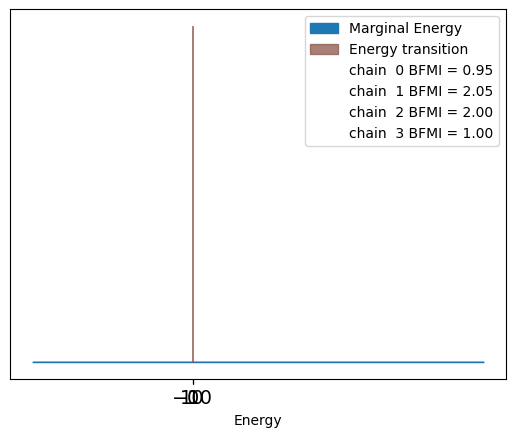

X axis values (energy):
[33.67680141 34.97948608 34.19686269 ... 37.31780408 36.63326256
 37.17013387]


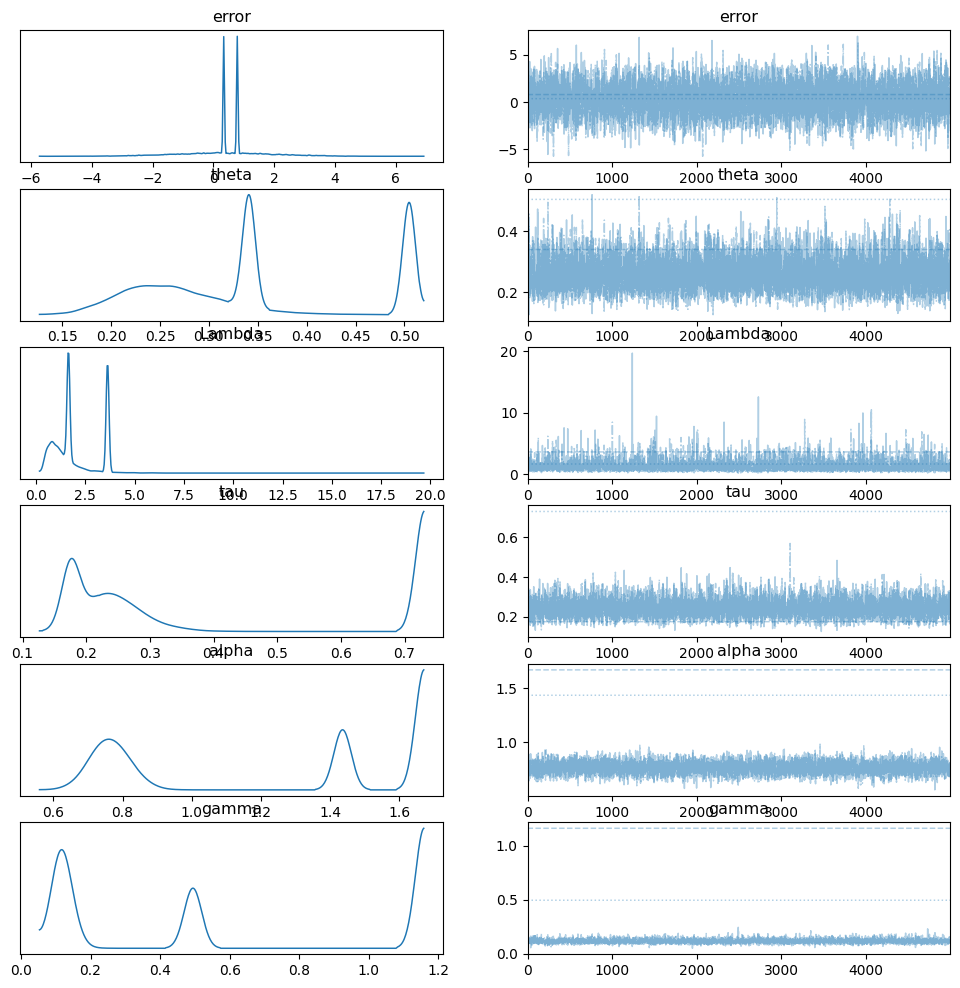

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta   0.341  0.106   0.202    0.505      0.050    0.023       5.0     104.0   
Lambda  1.975  1.160   0.522    3.602      0.481    0.193       8.0     101.0   
tau     0.349  0.225   0.176    0.731      0.111    0.062       5.0       4.0   
alpha   1.159  0.406   0.702    1.672      0.202    0.041       5.0      96.0   
gamma   0.473  0.425   0.099    1.159      0.212    0.103       5.0     111.0   
error   0.458  1.219  -2.463    2.869      0.051    0.294      54.0      99.0   

        r_hat  
theta    2.32  
Lambda   2.37  
tau      2.24  
alpha    2.29  
gamma    3.41  
error    1.75  
PyMC fitting time: 12649.21 seconds


In [5]:
# Pymc
start_time_pymc = time.time()

trace = pymc_wrapper(df, distro_estimates, INIT_VALUES, FACTOR=1, beta=0.88, energy_plot_flag=True, distri_plot_flag=True)

pymc_time = time.time() - start_time_pymc
print(f"PyMC fitting time: {pymc_time:.2f} seconds")

In [8]:

# MLS
start_time_MLS  = time.time()
estimates       = MLS_wrapper(df, INIT_VALUES, distro_estimates)
time_MLS        = time.time() - start_time_MLS



Optimization terminated successfully.
         Current function value: 17.710697
         Iterations: 921
         Function evaluations: 1506


In [9]:
#evaluation
# 
stan_predictions = stan_predict(stan_fit, df, FACTOR=FACTOR)
pymc_predictions = pymc_predict(trace, df, FACTOR=FACTOR, beta=0.88)
MLS_predictions  = minimize_predict(estimates, df, FACTOR=FACTOR, beta=0.88)


# Calculate ROC AUC performance

y_true = df['invest'].values
y_pred = np.array(stan_predictions)

roc_auc_stan    = roc_auc_score(y_true, y_score = np.array(stan_predictions))
roc_auc_pymc    = roc_auc_score(y_true, y_score = np.array(pymc_predictions))
roc_auc_MLS     = roc_auc_score(y_true, y_score = np.array(MLS_predictions))


print(f"Stan fitting time: {stan_time:.2f} seconds")
print(f"PyMC fitting time: {pymc_time:.2f} seconds")
print(f"MLS fitting time: {time_MLS:.2f} seconds")
print(f"ROC AUC: {roc_auc_stan:.4f} (Stan), {roc_auc_MLS:.4f} (PyMC), {roc_auc_MLS:.4f} (minimize)")

Stan fitting time: 3.65 seconds
PyMC fitting time: 12649.21 seconds
MLS fitting time: 5.56 seconds
ROC AUC: 0.7083 (Stan), 0.6726 (PyMC), 0.6726 (minimize)


In [ ]:
from IPython.display import clear_output

# Prepare a DataFrame to store AUC scores and fitting times for each subject
subjects = df_50.index.get_level_values(0).unique()
auc_results = pd.DataFrame(
    index=subjects,
    columns=[
        'roc_auc_stan', 
        # 'roc_auc_pymc', 
        'roc_auc_MLS',
        'stan_time', 
        # 'pymc_time', 
        'MLS_time'
    ]
)

subj_counter = 1
for subject in subjects:
    clear_output(wait=True)
    print(f"Processing subject {subj_counter}/{len(subjects)}...")
    df_subj = df_25.loc[subject].copy()
    df_subj['invest'] = df_subj['invest'].astype(int)

    # Stan
    start_time_stan = time.time()
    stan_fit_subj   = stan_wrapper(df_subj, x0, INIT_VALUES=INIT_VALUES, FACTOR=FACTOR, beta=beta)
    stan_time_subj  = time.time() - start_time_stan
    stan_pred       = stan_predict(stan_fit_subj, df_subj, FACTOR=FACTOR)

    # # PyMC
    # start_time_pymc = time.time()
    # trace_subj = pymc_wrapper(df_subj, distro_estimates, INIT_VALUES, FACTOR=FACTOR, beta=beta, energy_plot_flag=False, distri_plot_flag=False)
    # pymc_time_subj = time.time() - start_time_pymc
    # pymc_pred = pymc_predict(trace_subj, df_subj, FACTOR=FACTOR, beta=beta)

    # MLS
    start_time_MLS = time.time()
    estimates_subj = MLS_wrapper(df_subj, INIT_VALUES, distro_estimates)
    MLS_time_subj  = time.time() - start_time_MLS
    MLS_pred       = minimize_predict(estimates_subj, df_subj, FACTOR=FACTOR, beta=beta)

    y_true_subj = df_subj['invest'].values

    auc_results.loc[subject, 'roc_auc_stan'] = roc_auc_score(y_true_subj, stan_pred)
    # auc_results.loc[subject, 'roc_auc_pymc'] = roc_auc_score(y_true_subj, pymc_pred)
    auc_results.loc[subject, 'roc_auc_MLS'] = roc_auc_score(y_true_subj, MLS_pred)
    auc_results.loc[subject, 'stan_time'] = stan_time_subj
    # auc_results.loc[subject, 'pymc_time'] = pymc_time_subj
    auc_results.loc[subject, 'MLS_time'] = MLS_time_subj
    
    subj_counter += 1
    
auc_results.to_csv('auc_results_by_subject.csv')
auc_results


In [17]:
auc_results

,roc_auc_stan,roc_auc_MLS,stan_time,MLS_time
subject,,,,
11112,0.833333,0.666667,2.292673,5.368245
111,0.640351,0.640351,2.397949,3.885127
14,0.530702,0.530702,2.068109,7.397448
18670,0.515873,0.515873,2.17725,3.318891
1970,0.587302,0.515873,1.885319,6.553073
2301,0.875,0.875,1.83191,7.459708
24574,0.691558,0.675325,1.945755,6.246055
24614,NaN,NaN,1.673032,3.521249
24683,0.615079,0.615079,1.871789,5.930717


In [13]:
auc_results.mean()

roc_auc_stan     0.676502
roc_auc_MLS      0.660236
stan_time        2.113453
MLS_time        12.001853
dtype: object

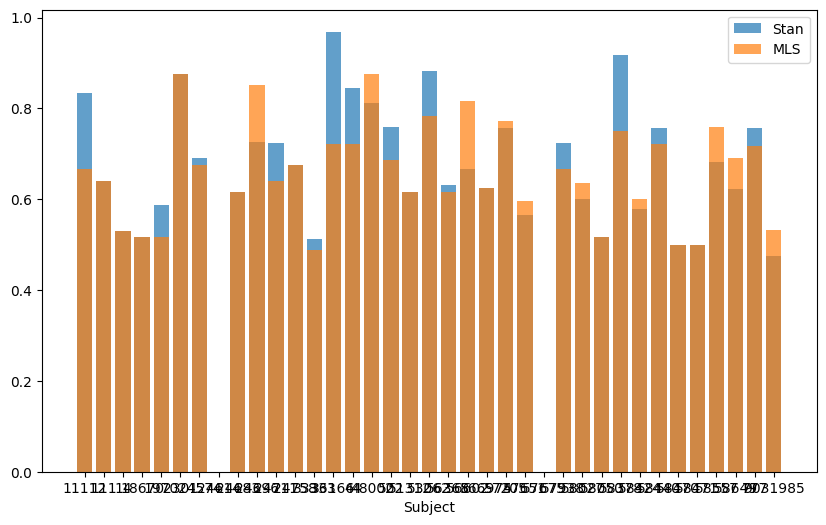

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(auc_results.index, auc_results['roc_auc_stan'], label='Stan', alpha=0.7)
plt.bar(auc_results.index, auc_results['roc_auc_MLS'], label='MLS', alpha=0.7)
plt.xlabel('Subject')   
plt.legend()